## Predicted VS True System Class for Flow Reactor and Batch Data

In [59]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from util import plot_confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [77]:
data_ind1 = pandas.read_csv("../xrsdkit_modeling/batch_pd_nanoparticles/dataset/dataset_index.csv")
data_ind1 = data_ind1.dropna(subset=['experiment_id'])
data_ind2 = pandas.read_csv("../xrsdkit_modeling/flowreactor_pd_nanoparticles/dataset/dataset_index.csv")
data_ind2 = data_ind2.dropna(subset=['experiment_id'])

In [78]:
data_ind1['dataset'] = 'batch_pd_nanoparticles'
data_ind2['dataset'] = 'flowreactor_pd_nanoparticles'

In [79]:
data_ind = pandas.concat([data_ind1,data_ind2])

In [80]:
data_ind.shape

(1805, 6)

In [81]:
data = pandas.read_csv("../xrsdkit_modeling/models_all_data/main_classifier_results.csv")

In [82]:
data.system_class.value_counts()

diffuse                                432
diffuse__diffuse                       224
crystalline                            118
unidentified                            91
disordered                              81
diffuse__disordered                     57
diffuse__crystalline                    52
diffuse__diffuse__crystalline           43
diffuse__diffuse__disordered            34
diffuse__disordered__crystalline        24
disordered__disordered__crystalline     10
disordered__crystalline                  7
disordered__disordered                   2
Name: system_class, dtype: int64

### Prediction of the System Class 

1. The binary classifiers were trained using "5 folders cross validation". To avoid having similar samples in the training and testing sets, for each model, the data were grouped in the folders by the first component of PCA. From each train/test split we got the predicted labels for "test" data. After this step each sample had predicted values for "diffuse_binary_pr" and "disordered_binary_pr". 


2. For each combination of "diffuse", "disordered", and "crystalline" labels a multiclass classifier was trained (for this particular dataset each of these classifiers had only two classes, but it is possible that there will be more classes for another dataset, so, we treads these classifiers as "multiclass" classifiers). 

    2.1 For the samples that include only "diffuse" populations, the classifier classified the samples into "diffuse" and "diffuse__diffuse."
    
    2.2 For the samples that include both "diffuse" and "disordered" populations, the classifier classified the samples into "diffuse__disordered" and "diffuse__diffuse__disordered."
    
    2.3 For the samples that include both "diffuse" and "crystalline" populations, the classifier classified the samples into "diffuse__crystalline" and "diffuse__diffuse__crystalline."
    
    
    
3. Samples with prediction "False" for"diffuse","disordered", and "crystalline" populations got label "Unidentified" for the System Class.


4. The inconsistent in the predicted labels was fixed. The samples that were misclassified by binary classifiers had inconsistent System Class. 

    For example, true label: diffuse = True, disordered = True; predicted labels:  diffuse = True, disordered = False. 
    
    When we made the prediction in step 2, we did not take into account predicted labels from binary classifiers. To train the model to distinguish "diffuse__diffuse__disordered" and "diffuse__disordered" we used the samples with true labels "True" for diffuse and disordered populations. Thus, this sample would be classified as "diffuse__diffuse__disordered" or "diffuse__disordered." To fix it, we update the prediction based on predicted values for "diffuse" and "disordered".

### Metrics of predicted System Class

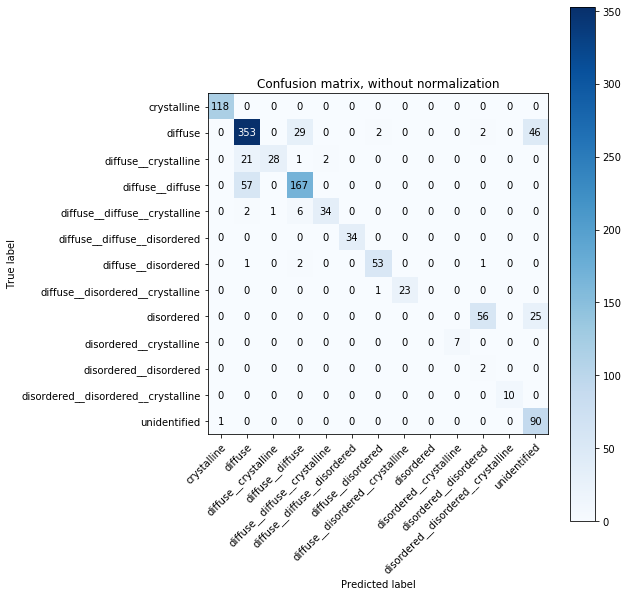

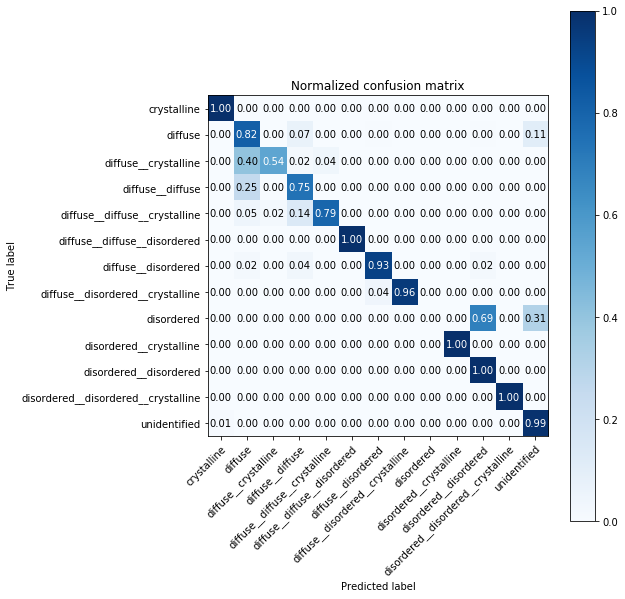

In [83]:
y_true = data['system_class']
y_pred = data['system_class_xval']
class_names = data['system_class'].unique().tolist()
class_names.sort()

plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

This matrix shows that the most common error is predicting "diffuse_diffuse" for the samples with true system class "diffuse" (we predict that the sample has two, not one diffuse population).

The second common error is predicting "diffuse_diffuse" for the samples with true system class "diffuse_diffuse_disordered" (the disordered population is not unidentified for this samples).

This facts can be explained that the majority of the samples has "diffuse_diffuse" system class:

In [84]:
print(classification_report(y_true, y_pred, target_names=class_names))

                                     precision    recall  f1-score   support

                        crystalline       0.99      1.00      1.00       118
                            diffuse       0.81      0.82      0.82       432
               diffuse__crystalline       0.97      0.54      0.69        52
                   diffuse__diffuse       0.81      0.75      0.78       224
      diffuse__diffuse__crystalline       0.94      0.79      0.86        43
       diffuse__diffuse__disordered       1.00      1.00      1.00        34
                diffuse__disordered       0.95      0.93      0.94        57
   diffuse__disordered__crystalline       1.00      0.96      0.98        24
                         disordered       0.00      0.00      0.00        81
            disordered__crystalline       1.00      1.00      1.00         7
             disordered__disordered       0.03      1.00      0.06         2
disordered__disordered__crystalline       1.00      1.00      1.00        1

from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support :
'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [85]:
data = pandas.merge(data, data_ind, on='sample_id')

In [86]:
missclassified = data[data['system_class'] != data['system_class_xval']]

In [87]:
missclassified.head()

,Unnamed: 0_x,experiment_id_x,sample_id,system_class,system_class_xval,diffuse_binary,disordered_binary,crystalline_binary,diffuse_binary_xval,diffuse_binary_pr,disordered_binary_xval,disordered_binary_pr,crystalline_binary_xval,crystalline_binary_pr,Unnamed: 0_y,experiment_id_y,yml_file,data_file,dataset
1,238,R0_201811,R0_201811_1541366472,diffuse,unidentified,True,False,False,False,False,False,False,False,False,267,R0_201811,gridsearch20_dz_bgsub.yml,gridsearch20_dz_bgsub.dat,flowreactor_pd_nanoparticles
6,259,R0_201811,R0_201811_1541364785,diffuse__diffuse,diffuse,True,False,False,True,True,False,False,False,False,289,R0_201811,gridsearch19_dz_bgsub.yml,gridsearch19_dz_bgsub.dat,flowreactor_pd_nanoparticles
12,242,R0_201811,R0_201811_1541293284,diffuse__diffuse,diffuse,True,False,False,True,True,False,False,False,False,271,R0_201811,gridsearch4_dz_bgsub.yml,gridsearch4_dz_bgsub.dat,flowreactor_pd_nanoparticles
17,233,R0_201811,R0_201811_1541361397,diffuse__diffuse,diffuse,True,False,False,True,True,False,False,False,False,262,R0_201811,gridsearch17_dz_bgsub.yml,gridsearch17_dz_bgsub.dat,flowreactor_pd_nanoparticles
20,257,R0_201811,R0_201811_1541363102,diffuse__diffuse,diffuse,True,False,False,True,True,False,False,False,False,287,R0_201811,gridsearch18_dz_bgsub.yml,gridsearch18_dz_bgsub.dat,flowreactor_pd_nanoparticles


### Visualization of misclassified samples

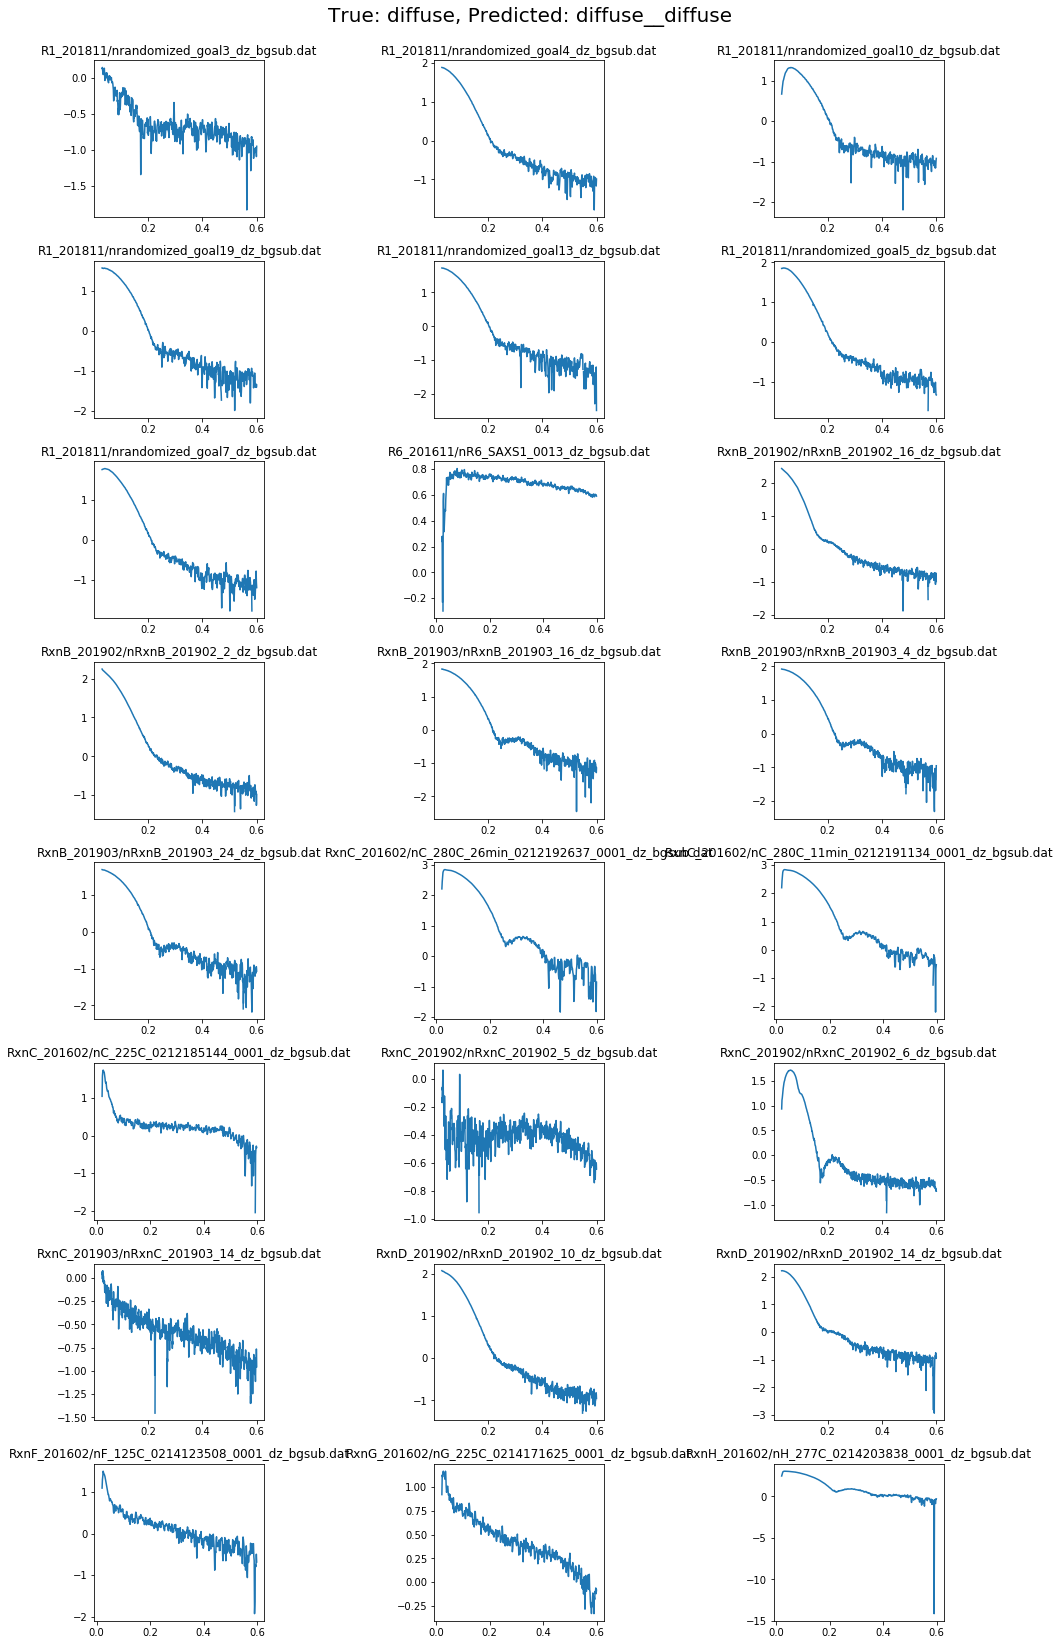

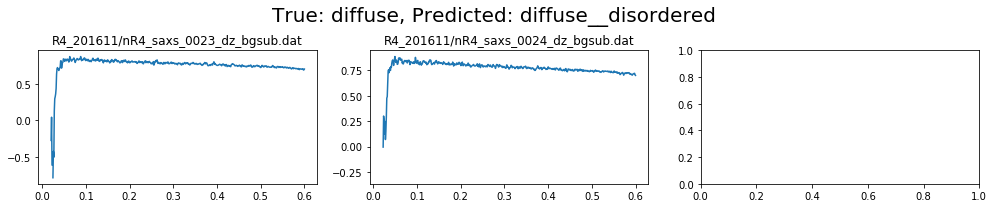

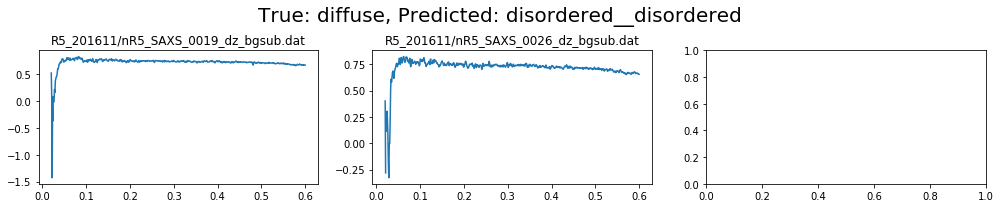

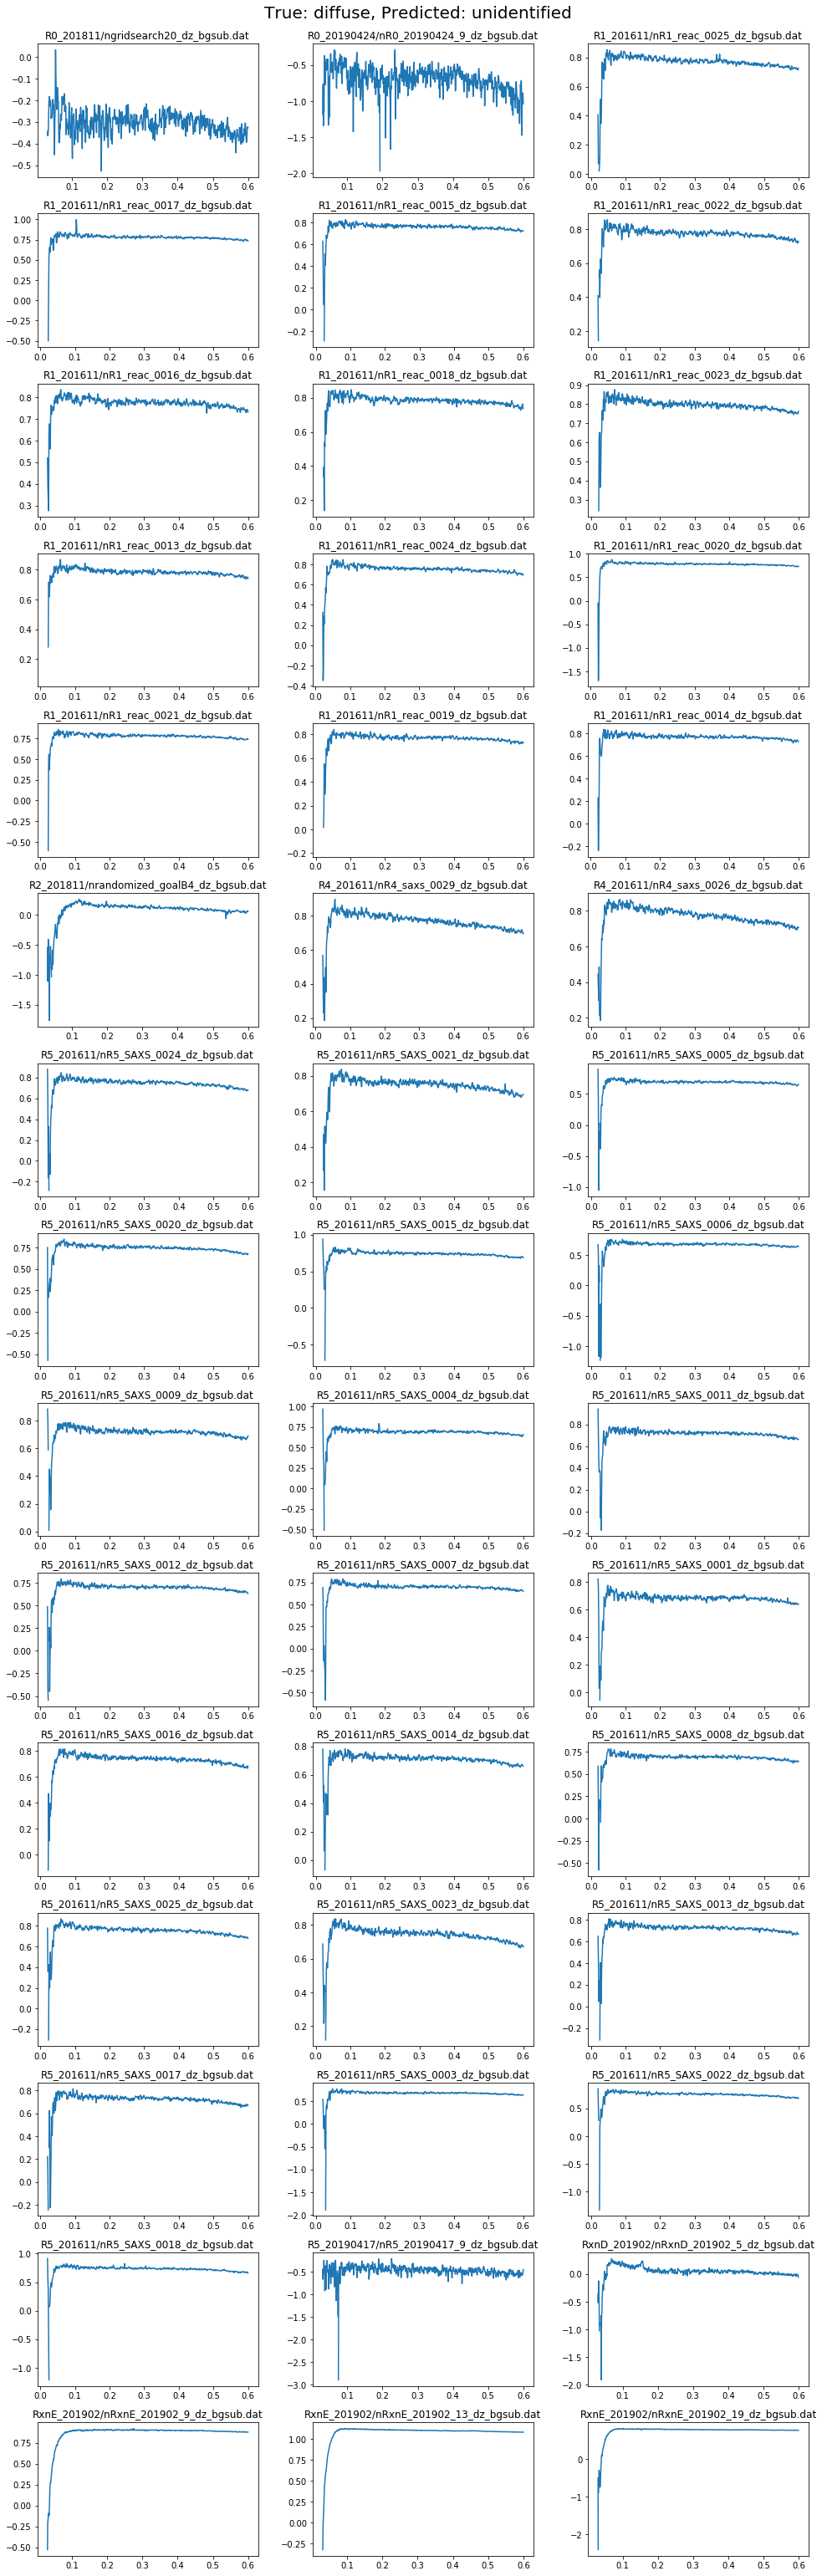

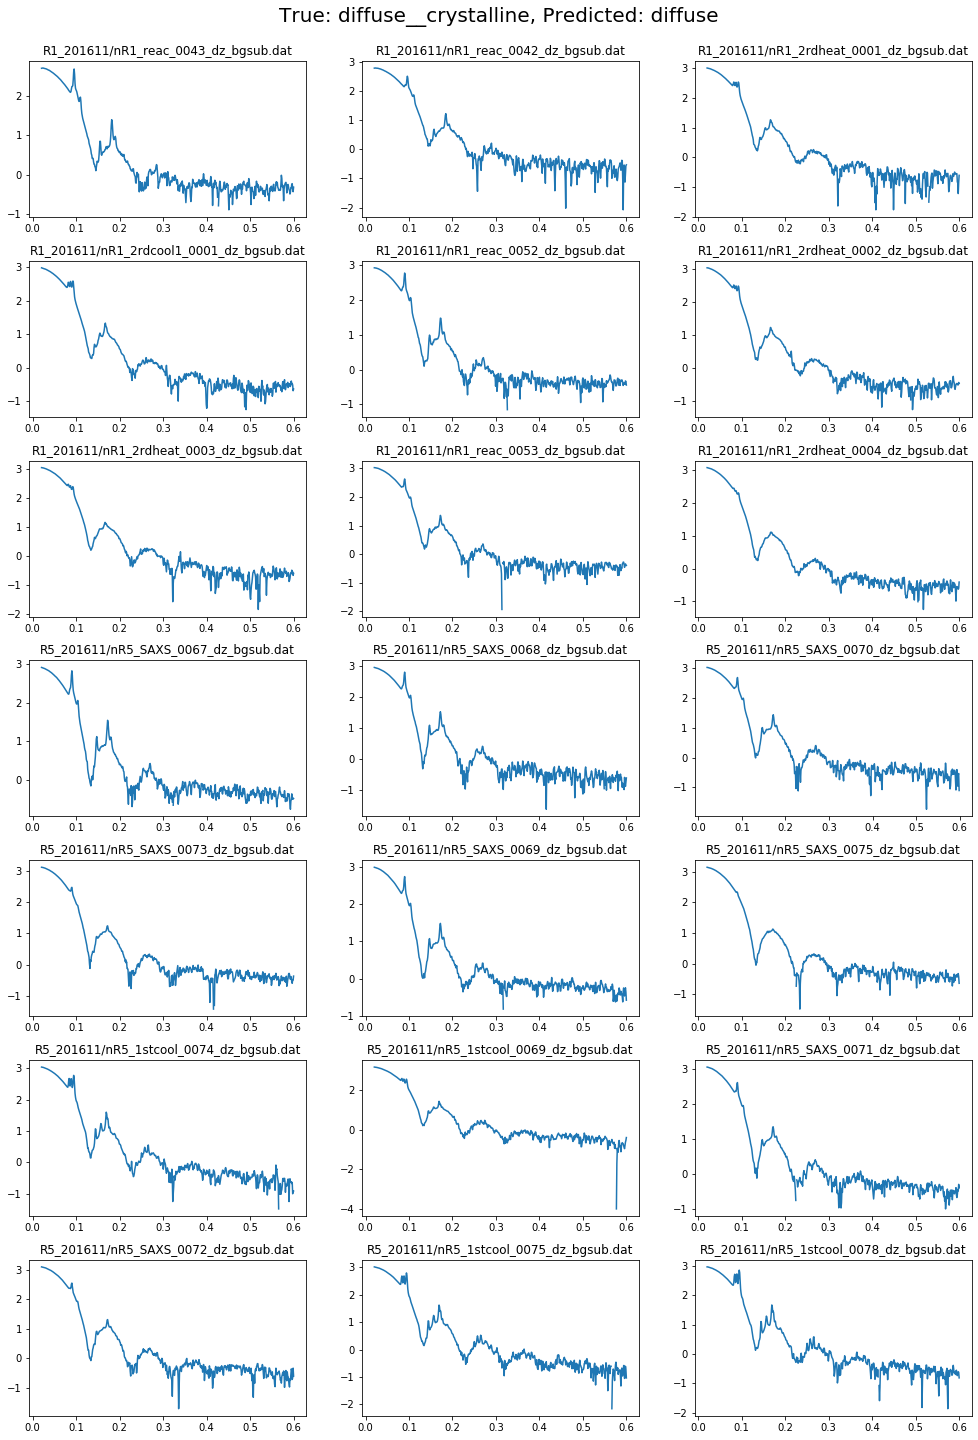

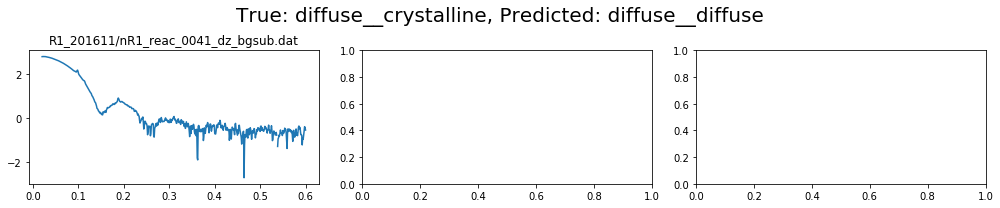

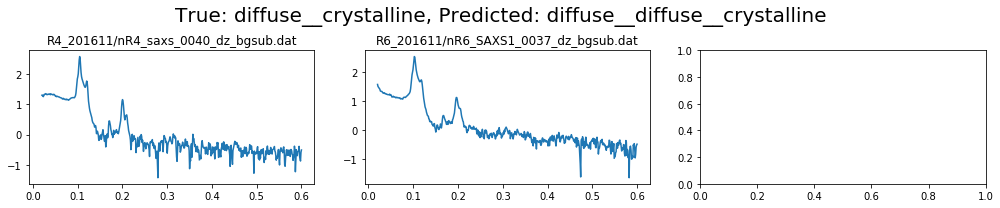

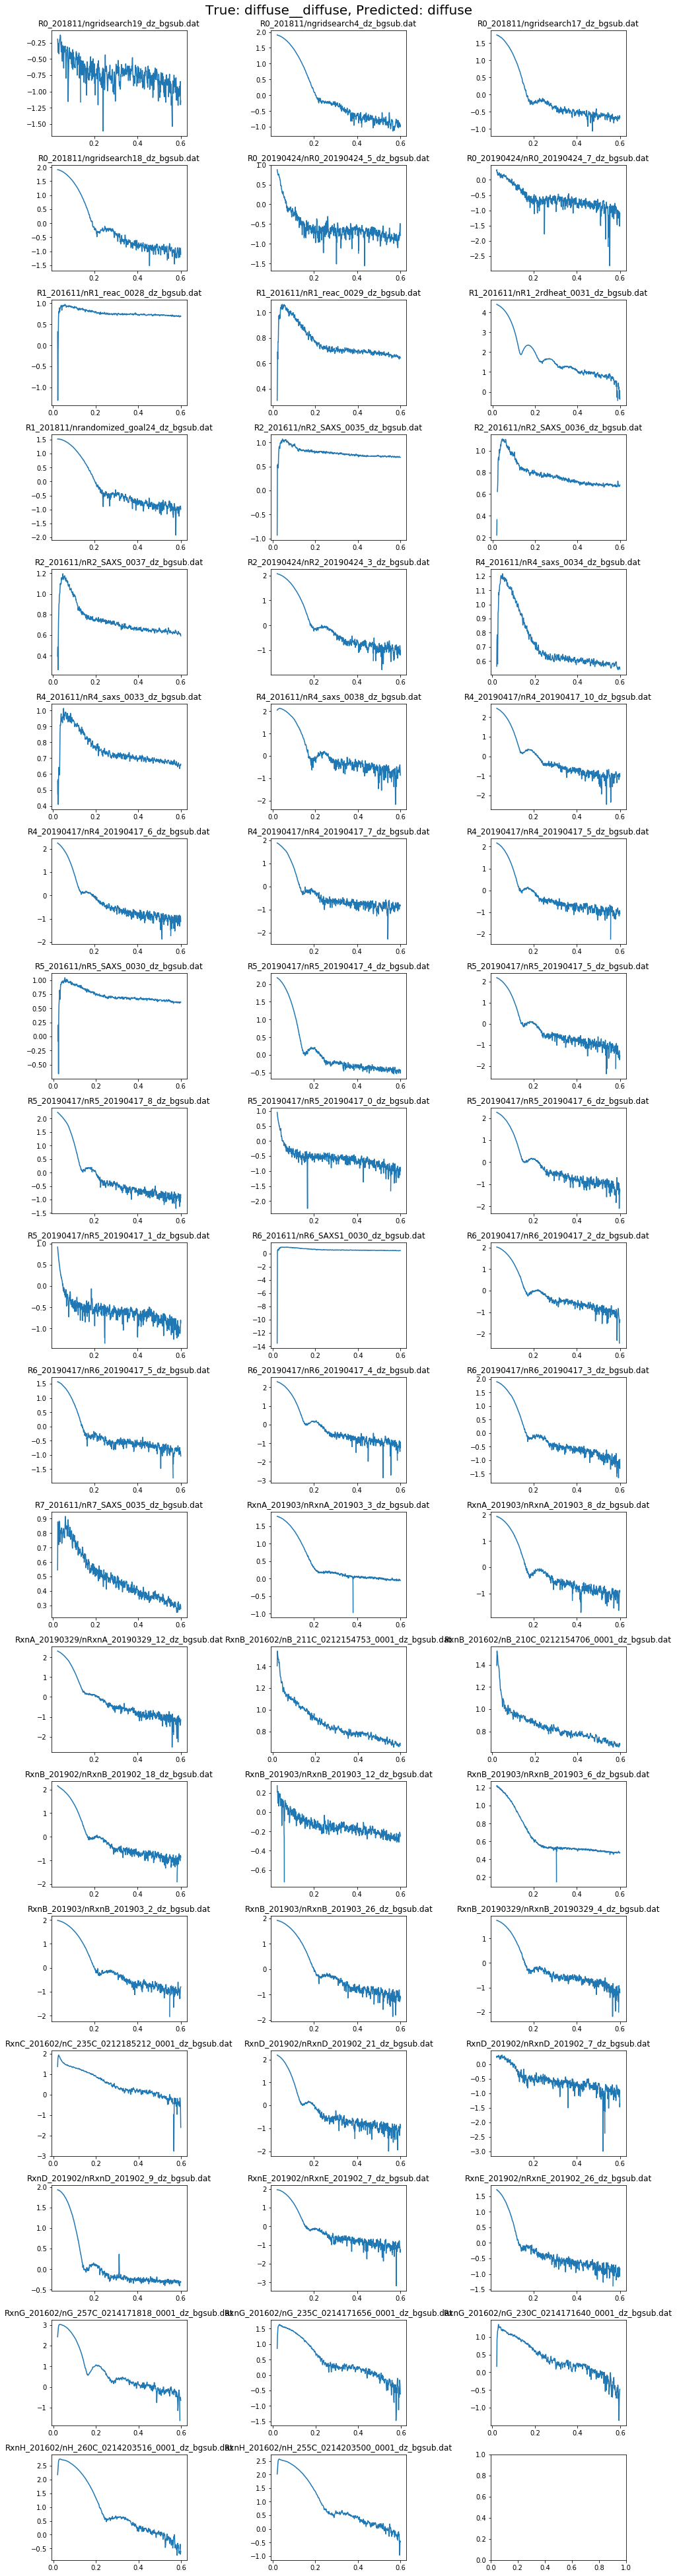

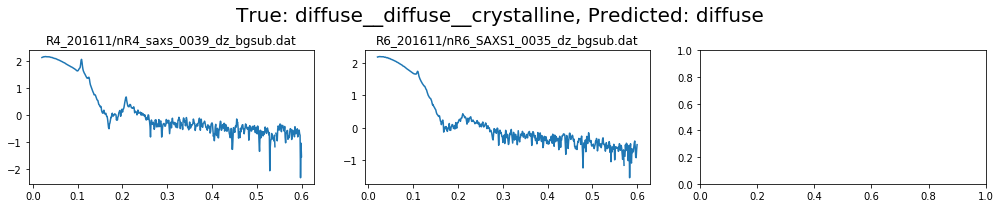

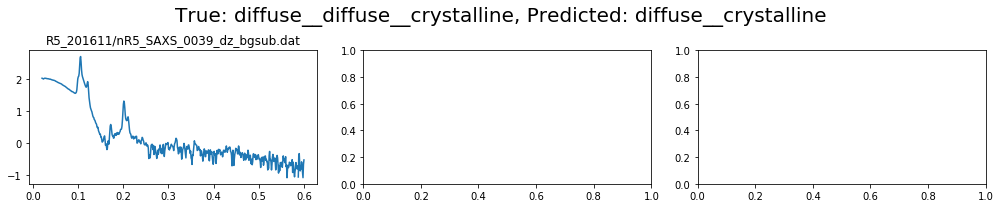

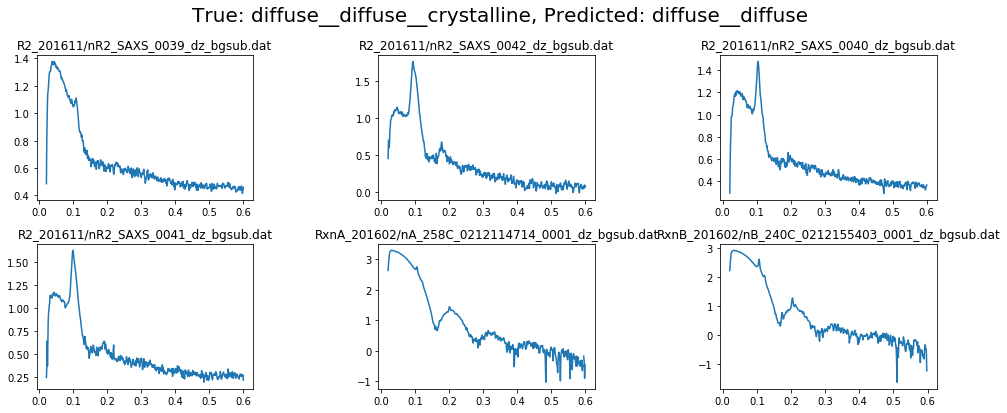

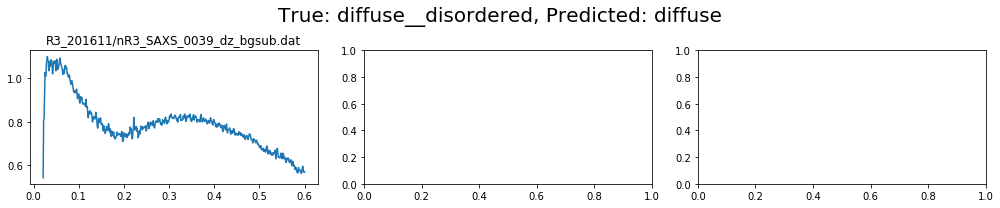

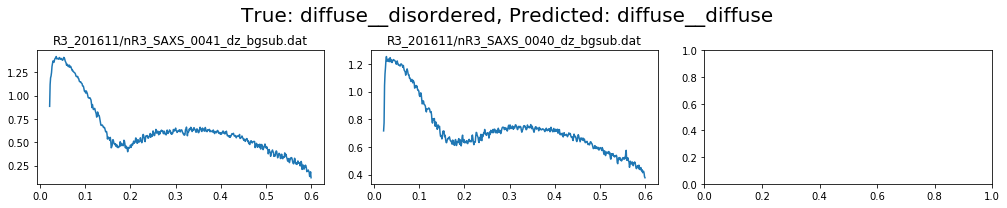

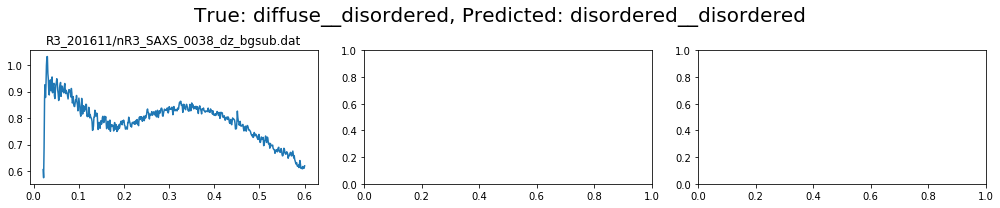

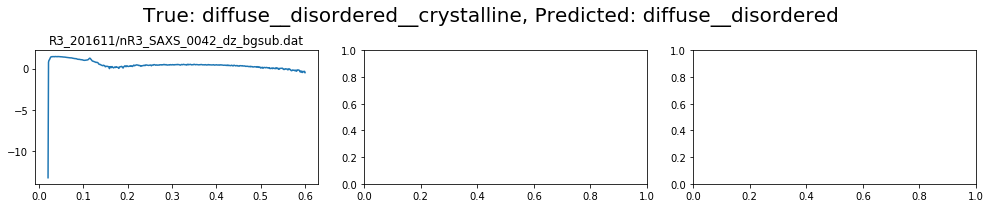

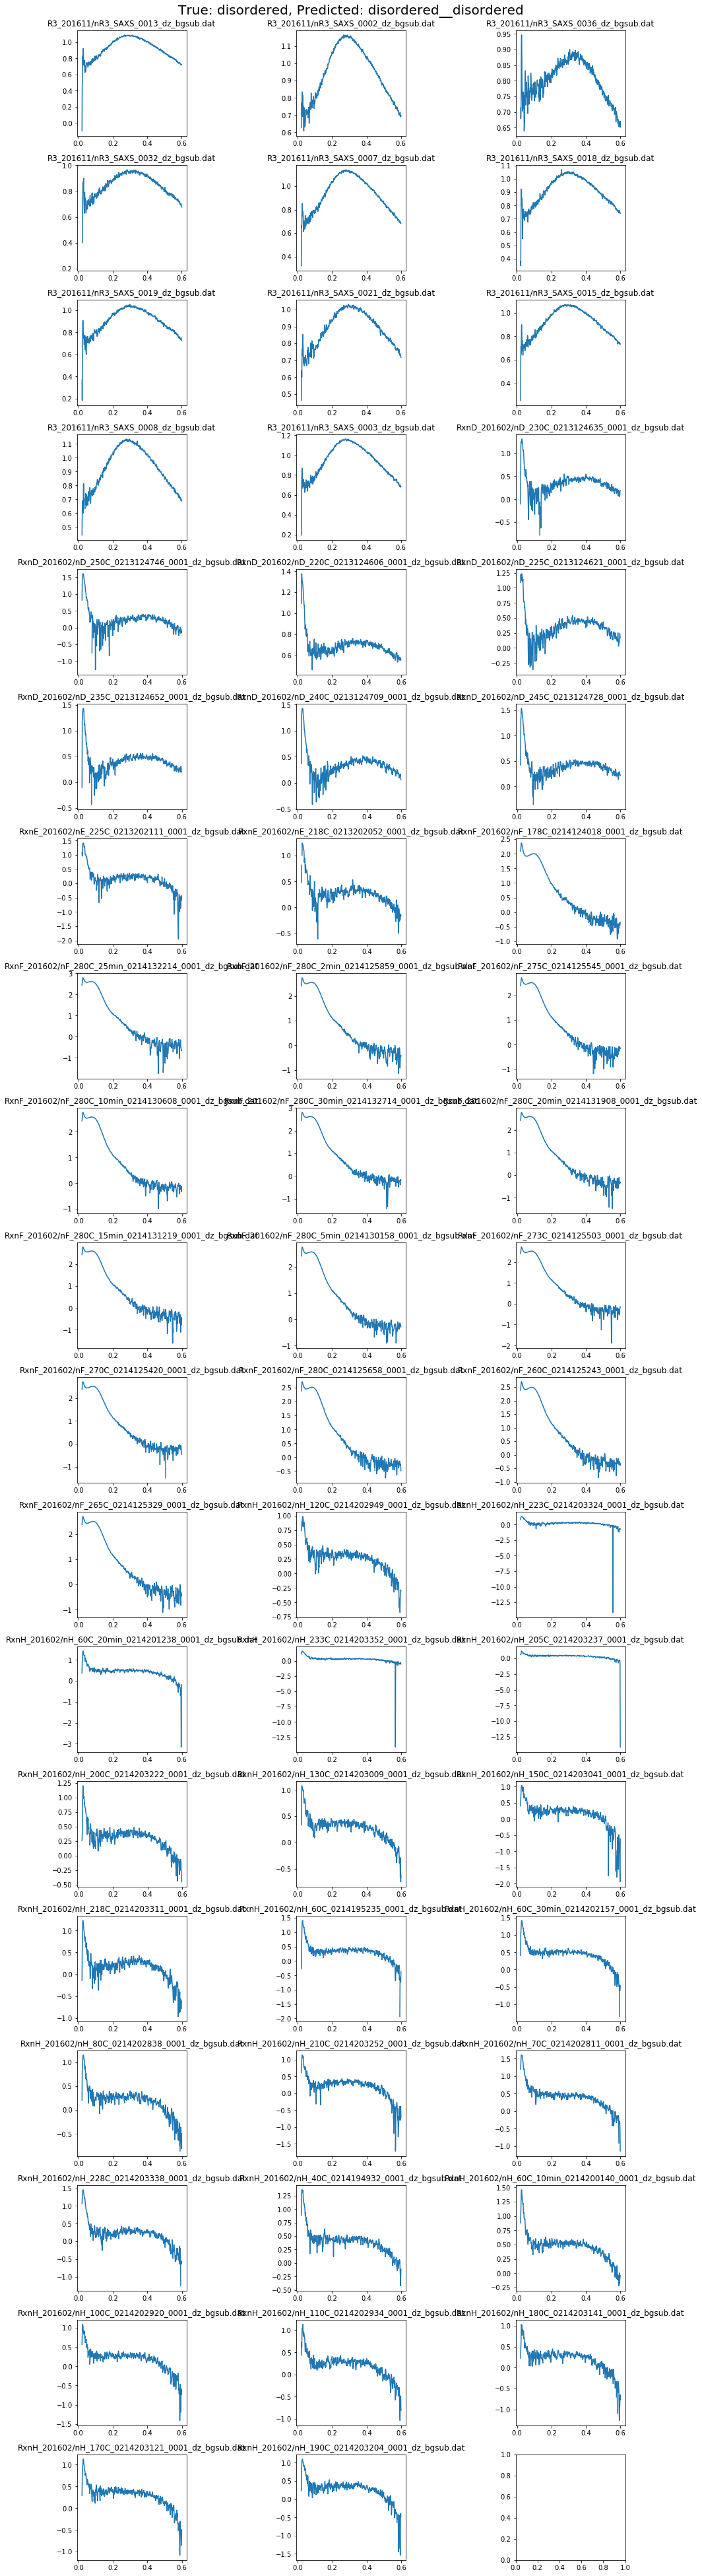

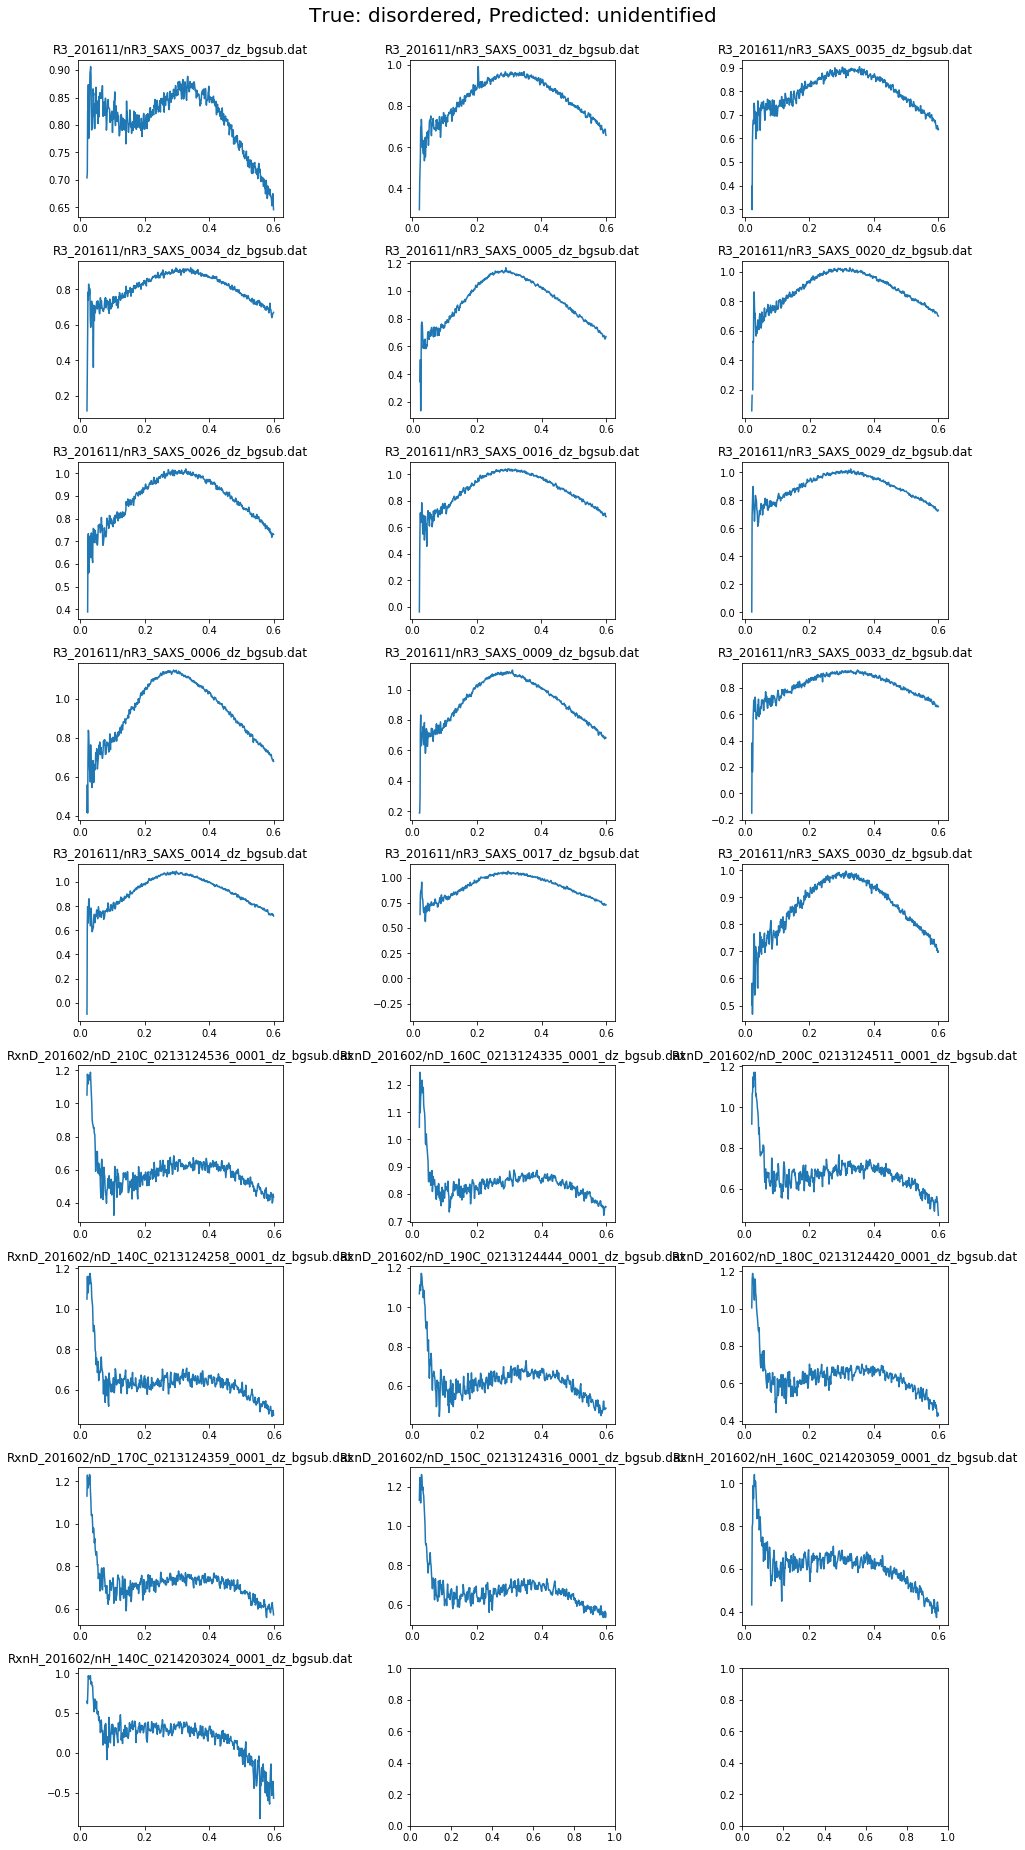

In [88]:
grs = missclassified.groupby(['system_class', 'system_class_xval'])
for name, gr in grs:
    ncols = 3
    nrows = len(gr)//3
    if len(gr)%3 !=0: nrows +=1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,nrows*3))
    axs = axes.flatten()
    title = "True: " + name[0] + ", " + "Predicted: " + name[1]
    fig.suptitle(title, fontsize=20)
    #st.set_y(0.92)
    for n in range(len(gr)): 
        d = gr.iloc[n]
        exp = d['experiment_id_x']
        file_name = d['data_file']
        dataset = d['dataset']
        f = open('../xrsdkit_modeling/'+ dataset +'/dataset/' + exp + '/' + file_name,'r')
        q_I = np.loadtxt(f,dtype=float)
        I_log = np.log10(q_I[:, 1])
        axs[n].plot(q_I[:, 0], I_log)
        axs[n].set_title(exp + "/n" + file_name)
    top = 0.1 / nrows**0.5
    fig.tight_layout(rect=[0, 0.03, 1, 1.0-top])

Misclassified samples shows:

1. We need to find a new features to destinies samples with singe and double diffuse populations. Possible, this features can be based on the shape of the low Q.

2. A lot of "disordered" samples were labeled as "Unidentified" - we need to find a new feature to distinguish them.

2. If a disordered population represented by a small "bump" or "pick", the model does not recognize it. So, we need a new feature or some features for such samples. 

